In [1]:
# Packages / libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.stats as stats

In [2]:
data = pd.read_csv('barcelona_house_pricing27_10_21.csv')

In [3]:
def preprocessing_data(df):
    df = df.copy()
    # Dropeamos columnas no necsarias
    df = df.drop('codigo', axis=1) # Columna innecesaria
    df = df.drop('link', axis=1) # Columna innecesaria
    df = df.drop('contrato', axis=1) # No nos aporta información
    df = df.drop('titulo', axis=1) # Nos aporta información innncesaria

    # Eliminamos filas con valores nulos en la columna precio o metros
    df = df.dropna(subset=['precio']) 
    # # Eliminamso filas con valores nulos en ambas columnas: habitaciones y banyos
    df = df.dropna(subset=['habitaciones', 'banyos', 'metros'], thresh=2)

    # Eliminamos los datos anómalos
    df = df[df['banyos']!=121]
    
    columns_to_encode = ['barrio']

    for column in columns_to_encode:
        # Obtenemos la matriz dummy
        dummies_column = pd.get_dummies(df[column], prefix=column)
        # Unión de las columnas dummies con el dataframe data
        df_ = pd.concat([df, dummies_column], axis=1)
        # Eliminamos la columa ya encoded
        df_ = df_.drop(column, axis=1)
    
    # Split el dataset en X e y
    y = df_['precio']
    X = df_.drop('precio', axis=1)

    # Imputación de los datos con KNN
    knn_imputer = KNNImputer()
    knn_imputer.fit(X)
    X = pd.DataFrame(knn_imputer.transform(X), index=X.index, columns=X.columns)

    df['habitaciones'] = X['habitaciones']
    df['banyos'] = X['banyos']
    df['metros'] = X['metros']
    
    return df

In [4]:
df = preprocessing_data(data)

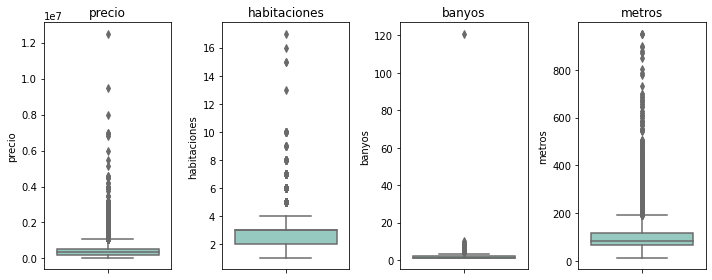

In [5]:
#Hacemos boxplot de las variables para detectar outliers, detectamos el valor 121 en baños y lo eliminamos en el preprocesado
numerical_cols = ['precio', 'habitaciones', 'banyos', 'metros']
plt.subplots(1,4, figsize=(10,4))
i=1
for column in numerical_cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=column, data=data, palette="Set3")
    plt.title(column)
    i+=1
plt.tight_layout()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71]),
 [Text(0, 0, 'Sant Pere-Santa Caterina-La Ribera (Distrito Ciutat Vella. Barcelona Capital)'),
  Text(1, 0, 'La Barceloneta (Distrito Ciutat Vella. Barcelona Capital)'),
  Text(2, 0, 'Sant Antoni (Distrito Eixample. Barcelona Capital)'),
  Text(3, 0, 'Can Baró (Distrito Horta-Guinardó. Barcelona Capital)'),
  Text(4, 0, 'Vallcarca-Els Penitents (Distrito Gràcia. Barcelona Capital)'),
  Text(5, 0, 'El Baix Guinardó (Distrito Horta-Guinardó. Barcelona Capital)'),
  Text(6, 0, 'El Carmel (Distrito Horta-Guinardó. Barcelona Capital)'),
  Text(7, 0, 'El Guinardó (Distrito Horta-Guinardó. Barcelona Capital)'),
  Text(8, 0, 'Horta (Distrito Horta-Guinardó. Barcelona Ca

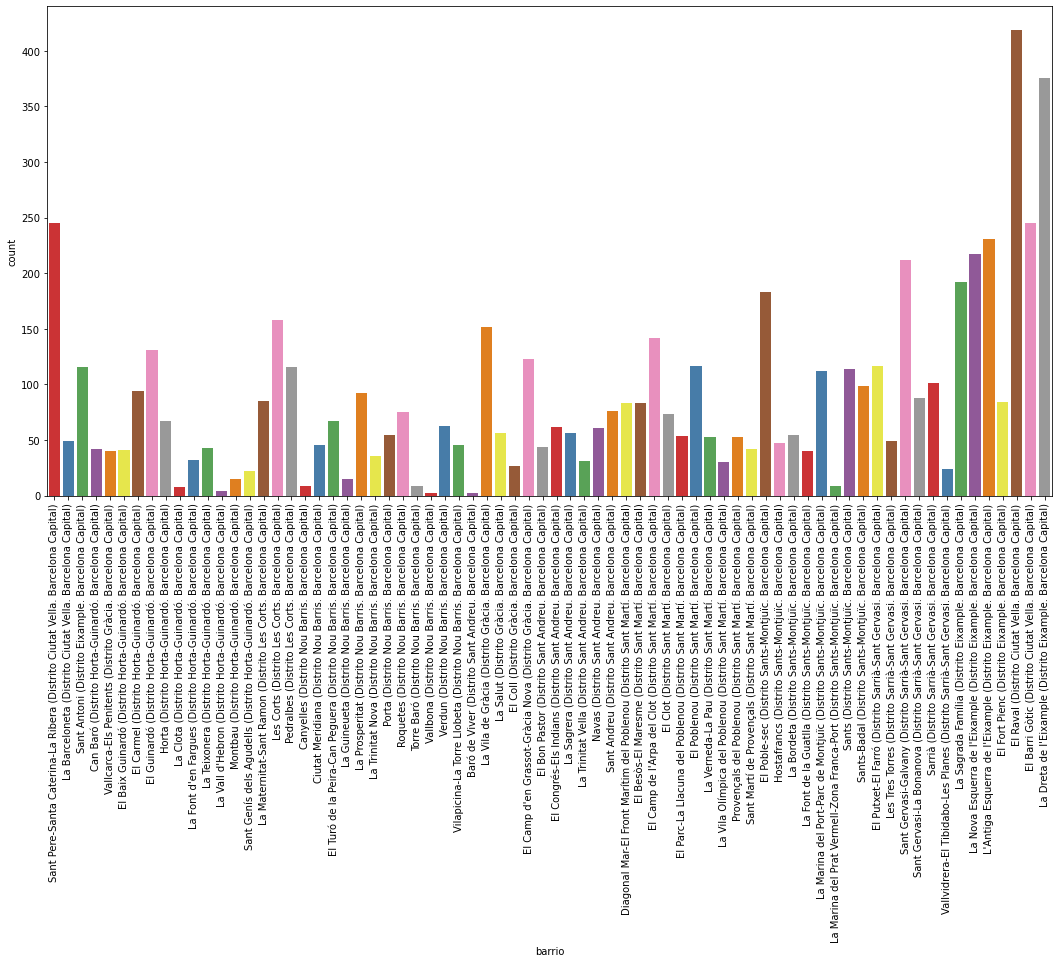

In [6]:
#Mostramos la cantidad de viviendas por barrio
plt.figure(figsize=(18,9))
df_order = df.groupby(['barrio'])['barrio'].count()

ax = sns.countplot(x='barrio', data=df, palette="Set1")
plt.xticks(rotation=90)

C:\Users\marcn\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\marcn\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\marcn\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

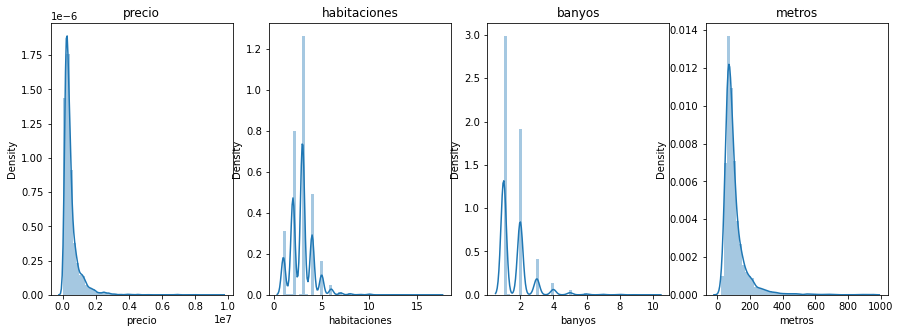

In [7]:
#Mostramos la distribución de las variables numéricas
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
axs = np.ravel(axs)
for i, col in enumerate(numerical_cols):
    plt.sca(axs[i])
    sns.distplot(df[col])
    plt.title(col)
    
plt.show()

In [8]:
# Normalidad de los residuos D'Agostino's K-squared test
for column in ['precio', 'habitaciones', 'banyos', 'metros']:
    k2, p_value = stats.normaltest(df[column])
    print(f"Variable {column}: Estadítico = {k2}, p-value = {p_value}")

Variable precio: Estadítico = 6411.238963285194, p-value = 0.0
Variable habitaciones: Estadítico = 2695.111052498249, p-value = 0.0
Variable banyos: Estadítico = 3373.6737036275003, p-value = 0.0
Variable metros: Estadítico = 5628.475871980806, p-value = 0.0


In [9]:
#Homocedasticidad de la varianza
#Test Levene
for column in ['habitaciones', 'banyos', 'metros']:
    k2, p_value = stats.levene(df["precio"], df[column], center='median')
    print(f"Test Levene, Variable {column}: Estadítico = {k2}, p-value = {p_value}")
#Test Fligner
for column in ['habitaciones', 'banyos', 'metros']:
    k2, p_value = stats.fligner(df["precio"], df[column], center='median')
    print(f"Test Fligner, Variable {column}: Estadítico = {k2}, p-value = {p_value}")

Test Levene, Variable habitaciones: Estadítico = 2209.1936446356594, p-value = 0.0
Test Levene, Variable banyos: Estadítico = 2209.196387799599, p-value = 0.0
Test Levene, Variable metros: Estadítico = 2208.552297168789, p-value = 0.0
Test Fligner, Variable habitaciones: Estadítico = 7703.294796493196, p-value = 0.0
Test Fligner, Variable banyos: Estadítico = 7729.724444235875, p-value = 0.0
Test Fligner, Variable metros: Estadítico = 7627.147834381098, p-value = 0.0


In [10]:
#Correlación de las variables numéricas con el precio usando test Spearman
for column in ['habitaciones', 'banyos', 'metros']:
    r, p = stats.spearmanr(df["precio"], df[column])
    print(f"Test Spearman, Variable {column}: R^2 = {r}, p-value = {p}")

Test Spearman, Variable habitaciones: R^2 = 0.40749289314527815, p-value = 5.727774848301852e-249
Test Spearman, Variable banyos: R^2 = 0.7417706141920086, p-value = 0.0
Test Spearman, Variable metros: R^2 = 0.8159236532297508, p-value = 0.0


In [11]:
#Test de Kruskal-Wallis para ver si el precio es distinto entre barrios
barrioList=df['barrio'].unique()
compList=[]
for barrio in barrioList:
    compList.append(df.loc[df['barrio']==barrio]['precio'])

k , p = stats.kruskal(*compList)
print(f"Test Kruskal-Wallis: Estadístico = {k}, p-value = {p}")

Test Kruskal-Wallis: Estadístico = 3370.7707971859268, p-value = 0.0


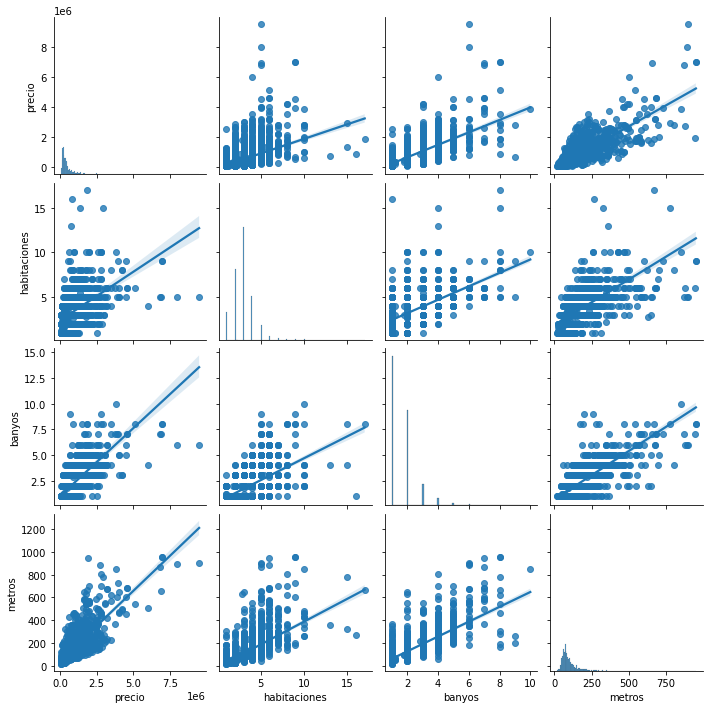

In [12]:
#Gráficos de las correlaciones de las variables numéricas
numerical_cols = ['precio', 'habitaciones', 'banyos', 'metros']
# Limitamos el dataset a las columnas tipo numérico
data2 = data[numerical_cols]
# Visualizamos las relaciones usando Pairplot 
pairplot_ = sns.pairplot(df, palette='Set1', kind="reg")

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
def preprocessing_for_model(df_pre):
    df = df_pre.copy()

    # Dummies de la columna barrio (variable categorica)
    columns_to_encode = ['barrio']
    for column in columns_to_encode:
        # Obtenemos la matriz dummy
        dummies_column = pd.get_dummies(df[column], prefix=column)
        # Unión de las columnas dummies con el dataframe data
        df = pd.concat([df, dummies_column], axis=1)
        # Eliminamos la columa ya encoded
        df = df.drop(column, axis=1)
    
    y = df['precio'].copy()
    X = df.drop('precio', axis=1).copy()

    # Training y Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)

    # Escalamos los datos de las variables
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [15]:
df = preprocessing_data(data)
X_train, X_test, y_train, y_test = preprocessing_for_model(df)

## Red neuronal

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [17]:
# Definimos el modelo
model = Sequential()
model.add(Dense(128, input_dim=75, activation='relu'))
model.add(Dense(64, activation='relu'))
#Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9728      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,049
Trainable params: 18,049
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs =100)

Epoch 1/100
126/126 [==============================] - 1s 5ms/step - loss: 508066234368.0000 - mae: 485467.2500 - val_loss: 499502120960.0000 - val_mae: 503745.9375
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 507300347904.0000 - mae: 484933.1250 - val_loss: 497772527616.0000 - val_mae: 502603.2500
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 504276221952.0000 - mae: 482936.5312 - val_loss: 492845203456.0000 - val_mae: 499508.7500
Epoch 4/100
126/126 [==============================] - 0s 3ms/step - loss: 497193910272.0000 - mae: 478586.2500 - val_loss: 482822782976.0000 - val_mae: 493345.7188
Epoch 5/100
126/126 [==============================] - 0s 3ms/step - loss: 484436213760.0000 - mae: 470706.3125 - val_loss: 466209308672.0000 - val_mae: 483137.2500
Epoch 6/100
126/126 [==============================] - 0s 3ms/step - loss: 465457872896.0000 - mae: 458873.1875 - val_loss: 443352383488.0000 - val_mae: 468774.0312
Epoch 7/10

Epoch 51/100
126/126 [==============================] - 0s 4ms/step - loss: 74117890048.0000 - mae: 145753.7031 - val_loss: 64392863744.0000 - val_mae: 150932.1250
Epoch 52/100
126/126 [==============================] - 0s 3ms/step - loss: 73679740928.0000 - mae: 145015.8281 - val_loss: 64219951104.0000 - val_mae: 150670.5469
Epoch 53/100
126/126 [==============================] - 0s 3ms/step - loss: 73206996992.0000 - mae: 144540.2344 - val_loss: 64047767552.0000 - val_mae: 150358.3750
Epoch 54/100
126/126 [==============================] - 0s 2ms/step - loss: 72724791296.0000 - mae: 144426.4062 - val_loss: 63830310912.0000 - val_mae: 149581.4844
Epoch 55/100
126/126 [==============================] - 0s 3ms/step - loss: 72309972992.0000 - mae: 143531.2969 - val_loss: 63647952896.0000 - val_mae: 149152.5625
Epoch 56/100
126/126 [==============================] - 0s 3ms/step - loss: 71879147520.0000 - mae: 143044.0469 - val_loss: 63505555456.0000 - val_mae: 148910.5156
Epoch 57/100
126

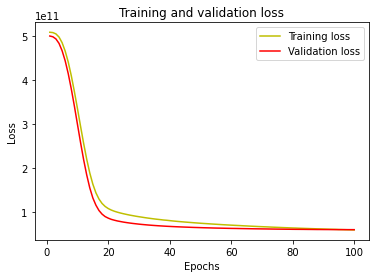

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
loss_and_metrics = model.evaluate(X_test, y_test, verbose=2)
print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

40/40 - 0s - loss: 71488290816.0000 - mae: 141960.7188 - 82ms/epoch - 2ms/step
Test Loss 71488290816.0
Test Accuracy 141960.71875


In [21]:
from sklearn.metrics import mean_squared_error, r2_score

Y_pred_nl = model.predict(X_test)
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, Y_pred_nl))

Coefficient of determination (R^2): 0.76


## Regresión lineal

In [22]:
from sklearn import linear_model

model_linear = linear_model.LinearRegression()
model_linear.fit(X_train, y_train)
Y_pred = model_linear.predict(X_test)

print('Coefficients:', model_linear.coef_)
print('Intercept:', model_linear.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, Y_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, Y_pred))

Coefficients: [-7.21354345e+04  9.48061701e+04  3.65216431e+05  1.00533515e+17
  4.07101916e+17  2.00946425e+17  4.47888837e+17  5.56380328e+17
  4.07101916e+17  9.82876695e+17  5.69509232e+17  4.19172548e+17
  7.10741458e+17  7.53674751e+17  5.90708493e+17  5.33743857e+17
  3.17342468e+17  5.05177158e+17  5.60792583e+17  7.07320970e+17
  4.42299326e+17  8.29442064e+17  6.86409309e+17  6.72076776e+17
  1.26746821e+18  5.00250404e+17  5.24402267e+17  4.58857040e+17
  9.31599543e+17  4.42299326e+17  4.64240712e+17  2.00946425e+17
  1.19776489e+18  3.75183260e+17  4.13182535e+17  2.65667494e+17
  6.61107458e+17  1.87986976e+17  5.78087476e+17  9.34115956e+17
  6.03050359e+17  8.65937859e+17  4.64240712e+17  4.74818587e+17
  4.30895811e+17  3.88273532e+17  3.54621687e+17  1.42147439e+17
  4.80016964e+17  3.54621687e+17  7.75718044e+17  7.94075833e+17
  4.47888837e+17  2.74964431e+17  4.90242202e+17  6.79283819e+17
  4.64240712e+17  4.53407219e+17  5.38351055e+17  5.47443608e+17
  6.7928381

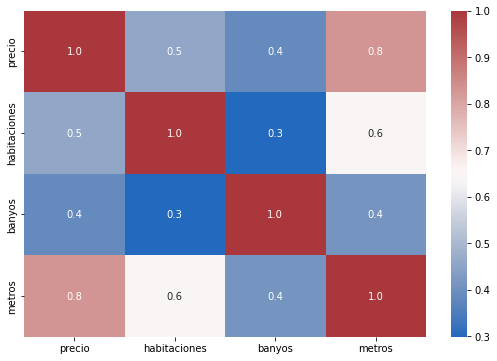

In [23]:
plt.figure(figsize=(9,6))
corr = data2.corr()
sns.heatmap(corr,annot=True,cmap='vlag',fmt=".1f")
plt.show()